<a href="https://colab.research.google.com/github/Czedros/CSE352-Machine-Learning-Assignments/blob/main/CSE352MidtermMakeupAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Name: [Enter Here]

I understand that my submission needs to be my own work: [Initials]

I understand that ChatGPT / Copilot / other AI tools are not allowed:  [Initials]

Total Points: **75**

Complete this notebook and submit it (save/print as pdf). Make sure all output is correct in the pdf before submitting (it sometimes gets cut off).

 The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Overview

In this assignment, you will:
- Implement the rules and structure for Ultimate Tic-Tac-Toe
- Design a basic Monte Carlo Tree Search (MCTS) agent
- Use MCTS to play against a human in the command line

#Setup

To start this assignemnt, We first install a few neccesary Packages.

In [ ]:
!pip install numpy

#Ultimate Tic-Tac-Toe

Ultimate Tic-Tac-Toe is a strategic extension of the classic Tic-Tac-Toe game. Rather than a single 3×3 grid, Ultimate Tic-Tac-Toe consists of a 3×3 grid where each cell contains another 3×3 Tic-Tac-Toe board. This layered setup creates a more complex game structure requiring players to think multiple moves ahead.

The game was first popularized online in the early 2010s and is designed to emphasize positional play, long-term strategy, and adaptation to an evolving board state. Each player, X or O, takes turns placing their mark in a cell of one of the smaller boards. However, the twist lies in the move constraints: a player’s move determines which of the nine small boards their opponent must play in next. Specifically, if a player places their mark in cell (i, j) of a small board, their opponent must play in the (i, j) small board on their next turn.

The objective is to win the larger game by winning three small boards in a row—horizontally, vertically, or diagonally—similar to classic Tic-Tac-Toe. A small board is won when a player has three marks in a row within it. If a player is sent to a board that is already won or drawn, they may play in any open board of their choosing.

Ultimate Tic-Tac-Toe presents a more intricate challenge than its predecessor and is a rich environment for studying game trees, simulation-based planning, and reinforcement learning. For more information about the game and strategic insights, refer to its [Wikipedia page](https://en.wikipedia.org/wiki/Ultimate_tic-tac-toe).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_ultimate_board(board, highlight=None):
    """
    Visualizes a 9x9 Ultimate Tic-Tac-Toe board.

    board: 9x9 numpy array with values 0 (empty), 1 (X), 2 (O)
    highlight: (row, col) tuple of active small board (0-2, 0-2)
    """
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)

    # Draw grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', lw=lw)
        ax.axvline(i, color='black', lw=lw)

    # Draw pieces
    for row in range(9):
        for col in range(9):
            val = board[row, col]
            if val == 1:
                ax.text(col+0.5, 8.5-row, 'X', ha='center', va='center', fontsize=16)
            elif val == 2:
                ax.text(col+0.5, 8.5-row, 'O', ha='center', va='center', fontsize=16)

    # Highlight the active board
    if highlight:
        y, x = highlight
        rect = patches.Rectangle((x*3, 9-(y+1)*3), 3, 3, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()


An usage of the visualizer code.

In [ ]:
# Example board
board = np.zeros((9, 9), dtype=int)
board[0, 0] = 1
board[1, 1] = 2
board[4, 4] = 1
board[8, 8] = 2

draw_ultimate_board(board, highlight=(1, 1))

#Part 1: Ultimate Tic-Tac-Toe [X Points]
In the first part, you will implement the mechanics of Ultimate Tic-Tac-Toe, defining how the game progresses and determining legal moves and win conditions.



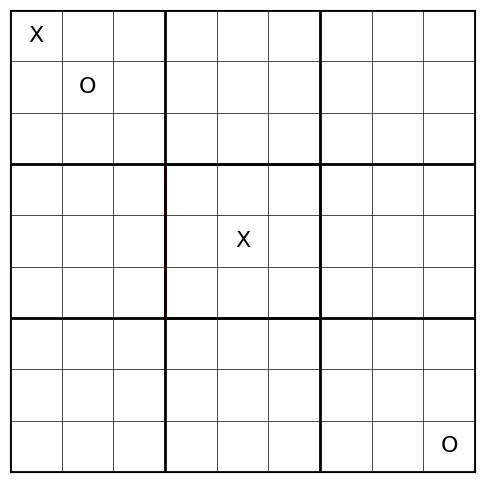